# Hypothesis Testing with Insurance Data (Core)
- Alexis Deviney
- 5/7/2022

For this assignment, we will be working with the [US Health Insurance Dataset](https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv) from [Kaggle](https://www.kaggle.com/teertha/ushealthinsurancedataset).

We have been asked to use our hypothesis testing skills to answer the following questions:

- Q1. Do smokers have higher insurance charges than non-smokers?
- Q2. Are men more likely to smoke than women?
- Q3. Do different regions have different charges, on average?

For each question, make sure to:

1. State your Null Hypothesis and Alternative Hypothesis
2. Select the correct test according to the data type and number of samples
3. Test the assumptions of your selected test.
4. Execute the selected test, or the alternative test (if you do not meet the assumptions)
5. Interpret your p-value and reject or fail to reject your null hypothesis 
6. Show a supporting visualization that helps display the result

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Q1. Do smokers have higher insurance charges than non-smokers?


Hypothesis:
- $H_0$: There is no significant difference between insurance charges of smokers vs. non-smokers.

- $H_A$: There is a significant difference between insurance charges of smokers vs. non-smokers. 

**Two-Sample T Test**

Assumptions
* No significant outliers
* Normality
* Equal Variance

In [3]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [4]:
smokers = df.loc[df['smoker']== 'yes'].copy()
non_smokers = df.loc[df['smoker']== 'no'].copy()

**Outliers**

In [5]:
smoker_outliers = np.abs(stats.zscore(smokers['charges'])) > 3
smoker_outliers.sum()

0

In [6]:
nonsmoker_outliers = np.abs(stats.zscore(non_smokers['charges'])) > 3
nonsmoker_outliers.sum()

24

There are no outliers in the *smoker* group, but there are 24 outliers in the *non-smoker* group. Will remove these outliers:

In [7]:
non_smokers = non_smokers.loc[~nonsmoker_outliers]

In [8]:
non_smokers.shape

(1040, 7)

**Normality**

In [9]:
result = stats.normaltest(smokers['charges'])
result.pvalue

5.564930630036463e-14

In [10]:
result = stats.normaltest(non_smokers['charges'])
result.pvalue

2.6945416315543976e-36

In [11]:
smokers.shape

(274, 7)

In [12]:
non_smokers.shape

(1040, 7)

The p-values for both groups are less than 0.05 which means the data is NOT normally distributed.  However, our our sample sizes are large enough to proceed without satisfying this test by the Central Limit Theorem.

$n_1 = 274 >> 15$

$n_2 = 1040 >> 15$

**Equal Variance**

In [13]:
result = stats.levene(smokers['charges'], non_smokers['charges'])
print(result)

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)


$p < 0.05$ so these groups do not have equal variances. Therefore, will use Welch's T-test by adding the parameter `equal_var = False`  to `ttest_ind`

In [14]:
stats.ttest_ind(smokers['charges'], non_smokers['charges'], equal_var = False)

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

$p < \alpha $, therefore we reject the null hypothesis and conclude there is a significant difference between the charges of smokers vs non-smokers.

In [15]:
smokers['charges'].mean()

32050.23183153284

In [16]:
non_smokers['charges'].mean()

7939.8608446721155

In [17]:
# plot_df is data without outliers
plot_df = pd.concat([smokers.loc[~smoker_outliers], 
                     non_smokers.loc[~nonsmoker_outliers]], axis=0)
plot_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
11,62,female,26.29,0,yes,southeast,27808.7251
14,27,male,42.13,0,yes,southeast,39611.7577
19,30,male,35.30,0,yes,southwest,36837.4670
23,34,female,31.92,1,yes,northeast,37701.8768
...,...,...,...,...,...,...,...
1332,52,female,44.70,3,no,southwest,11411.6850
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335


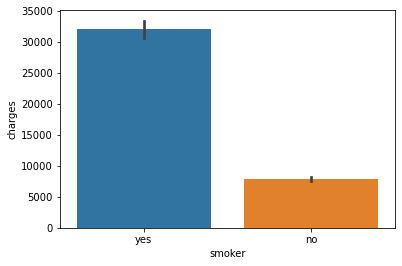

In [18]:
sns.barplot(data = plot_df, x = 'smoker', y = 'charges')

Therefore, we can conclude the charges of smokers is significantly *higher* than those of non-smokers.

## Q2. Are men more likely to smoke than women?

$H_0$: Men and women are equally likely to smoke.

$H_1$: There is a difference in likelihood to smoke between men and women.

**Chi-Square test**

Assumptions:

* There are two categorical variables (ordinal or nominal)
* The outcomes are independent

Groups of men and women satisfy the assumptions of the Chi-square test.

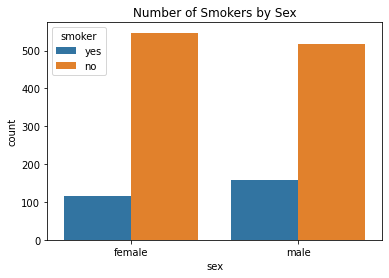

In [19]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers by Sex");

In [20]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [21]:
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result
p

0.006548143503580696

In [22]:
p < 0.05

True

$p < \alpha$ so we reject the null hypothesis and conclude that there is a difference in likelihood to smoke between men and women.

In [23]:
pd.crosstab(df['sex'], df['smoker'], normalize = True)


smoker,no,yes
sex,,
female,0.408819,0.085949
male,0.386398,0.118834


12% of men smoke compared to 9% of women. Since we have rejected the null hypothesis, we can ultimately conclude that men are *more likely* to smoke than women.

In [24]:
groups ={}

for region in df['region'].unique():
    groups[region] = df.loc[df['region']== region, 'charges']
    

groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

## Q3. Do different regions have different charges, on average?

$H_0$: There is no significant difference among the average charges of the different regions.

$H_1$: There is a significant difference among the averages charges of the different regions.

 
**ANOVA**

Assumptions
* No significant outliers
* Equal variance
* Normality



**Outliers**

In [25]:
for region, data in groups.items():

    outliers = np.abs(stats.zscore(data)) > 3
    print(f"There were {outliers.sum()} outliers in the {region} region.")

    data = data.loc[~outliers]
    groups[region] = data

There were 8 outliers in the southwest region.
There were 2 outliers in the southeast region.
There were 7 outliers in the northwest region.
There were 4 outliers in the northeast region.


**Normality**

In [26]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,317.0,7.728611e-22,97.223886
southeast,362.0,1.936990e-13,58.544942
northwest,318.0,2.940543e-19,85.341045
northeast,320.0,3.557877e-17,75.749565


Even though the data is NOT normally distributed (for all 4 groups), the sample sizes are large enough ($\ge$ 15) to proceed by the Central Limit Theorem.

**Equal Variance**

In [27]:
stats.levene(*groups.values())

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

The samples do NOT have equal variance. Therefore, we must do the non-parametric equivalent of ANOVA, Kruskal-Wallis.

In [28]:
stats.kruskal(*groups.values())

KruskalResult(statistic=6.914045702545643, pvalue=0.07468847911322242)

The Kruskal-Wallis hypothesis test returned a p-value greater than 0.05. Therefore we do not have enough evidence to reject the null hypothesis. There is no significant difference in charges among the different regions. 

In [29]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [30]:
df_no_outliers = pd.DataFrame()
for region in df['region'].unique():
    temp = df.loc[df['region']== region, ['charges', 'region']]
    temp['outlier'] = np.abs(stats.zscore(temp['charges'])) > 3
    df_no_outliers = pd.concat([temp.loc[temp['outlier'] == False], df_no_outliers])

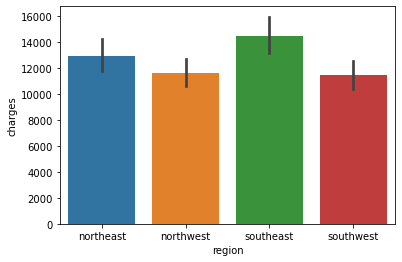

In [32]:
ax = sns.barplot(data=df_no_outliers, x='region', y='charges')